In [ ]:
import pandas as pd 
import numpy as np 
from collections import defaultdict
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import *
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.impute import SimpleImputer
from Binning import WOE
from sklearn.preprocessing import OneHotEncoder
from xarray import *
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from lightgbm import LGBMClassifier
import scorecardpy as sc
from lifelines import KaplanMeierFitter
from lifelines import CoxTimeVaryingFitter

# Survival Analysis 
The data exploration shows that around 30% of the clients having mortgage defaulted while 53% of them already made payement and the remaining 17% still did not pay and did not default either.  

In order to get insights about differences about customers' behaviours based on their balances, I will convert our episodic data into a static one by grouping using the ID and aggregating by the most recent default satatus.  

Then, I create two cohorts of customers; one with low outstanding balance at
origination time, we define low as the amounts lower than the amount in the 30% quantile, and the second with Average/High outstanding balance at origination time.  
Once the split is done, we do **Logrank** testing by setting no difference between groups as null hypothesis. The testing returns a significant *p-value* which is lower than 0.05, what tells that the null hypothesis is not correct and there is rather a difference between these two cohorts.  

I further check this by ploting the survival curves of both groups. From the curves, it is evident that the customers, who have average to high balance, have better probability survival as compared to the customers who have low balance until the 35th months where the survival probability of average/low balance clients drastically decreases to get under the curve of the low balance clients. To confirm this, I checked the survival probabality in the 25th month to find that the probability of survival for **Average/high balance 0.9845 > low balance 0.9435**, while in the 50th month the probability of survival for **Average/high balance 0.4735 > low balance 0.5763**.  

Next, I will fit a **Cox Proportional Hazard Model** while assuming time variation, using this list of features *["default_time", "hpi_time", "gdp_time", "uer_time","balance_time","interest_rate_time", "FICO_orig_time", "LTV_time"]*, in order explore how these covariates impact the survival probability function.  

The summary statistics below that we get from the fitted model, indicates the significance of the covariates in predicting the default risk. Where all the covariates are significant.  

When digging deeper into the effect of these covariates, I found that the most impacting variable is **interest_rate_time** since an additional interest rate overtime increases the probability to default by 18.744%, followed by **uer_time** that indicates that an increase in the unemployement rate will raise the probability of defaulting by 14.958%.

In [ ]:
Mortgage = pd.read_csv(Data + "/mortgage.csv")

In [ ]:
Mortgage.head()

,id,time,orig_time,first_time,mat_time,balance_time,LTV_time,interest_rate_time,hpi_time,gdp_time,...,REtype_SF_orig_time,investor_orig_time,balance_orig_time,FICO_orig_time,LTV_orig_time,Interest_Rate_orig_time,hpi_orig_time,default_time,payoff_time,status_time
0,1,25,-7,25,113,41303.42,24.498336,9.2,226.29,2.899137,...,1,0,45000.0,715,69.4,9.2,87.03,0,0,0
1,1,26,-7,25,113,41061.95,24.483867,9.2,225.10,2.151365,...,1,0,45000.0,715,69.4,9.2,87.03,0,0,0
2,1,27,-7,25,113,40804.42,24.626795,9.2,222.39,2.361722,...,1,0,45000.0,715,69.4,9.2,87.03,0,0,0
3,1,28,-7,25,113,40483.89,24.735883,9.2,219.67,1.229172,...,1,0,45000.0,715,69.4,9.2,87.03,0,0,0
4,1,29,-7,25,113,40367.06,24.925476,9.2,217.37,1.692969,...,1,0,45000.0,715,69.4,9.2,87.03,0,0,0


In [ ]:
Mortgage = Mortgage.dropna()

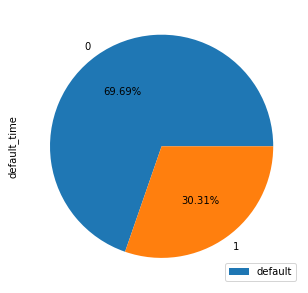

In [ ]:
Mortgage.groupby("id").agg({"default_time":np.max})["default_time"].value_counts().plot.pie(autopct='%.2f%%', figsize=(5,8))
plt.legend(["default"],loc="lower right")

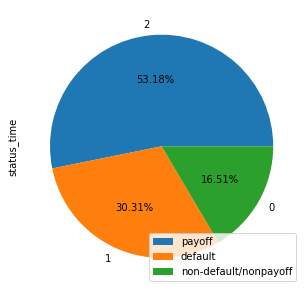

In [ ]:
Mortgage.groupby("id").agg({"status_time":np.max})["status_time"].value_counts().plot.pie(autopct='%.2f%%', figsize=(5,8))
plt.legend(["payoff","default","non-default/nonpayoff"],loc="lower right")

In [ ]:
Mortgage.groupby("id").agg({"default_time":np.max})["default_time"].value_counts()

0    34833
1    15149
Name: default_time, dtype: int64

In [ ]:
mort_static = Mortgage.groupby("id").agg(np.max).reset_index()

In [ ]:
df1 = mort_static.loc[mort_static["balance_orig_time"] >= mort_static["balance_orig_time"].quantile(.3),:]
df2 = mort_static.loc[mort_static["balance_orig_time"] < mort_static["balance_orig_time"].quantile(.3),:]

In [ ]:
from lifelines.statistics import logrank_test

# Null-Hypothesis: No difference between the two groups
res = logrank_test(df1['time'], df2['time'], event_observed_A=df1['default_time'],event_observed_B=df2['default_time'])

# We can reject the Null-Hypothesis (p < 0.05)
res.summary 

,test_statistic,p,-log2(p)
0,58.647544,1.886034e-14,45.591637


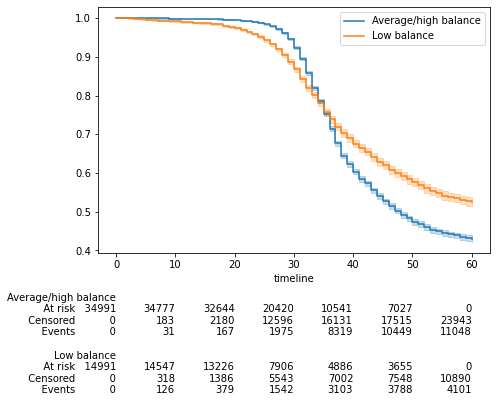

In [ ]:
# Compare two groups

kmf1 = KaplanMeierFitter()
kmf2 = KaplanMeierFitter()

fig, ax = plt.subplots(1,1 , figsize=(7,6))

# fit subset gender = male
ax = kmf1.fit(df1['time'], df1['default_time'], label='Average/high balance').plot_survival_function(ax=ax)

# fit subset gender = female
ax = kmf2.fit(df2['time'], df2['default_time'], label='Low balance').plot_survival_function(ax=ax)

from lifelines.plotting import add_at_risk_counts
add_at_risk_counts(kmf1, kmf2, ax=ax)
plt.tight_layout()

In [ ]:
# check survival probability after 25 months and 50 months
for i in (25,50): 
    print("probability of survival at time", i)
    print("Average balance", round(kmf1.predict(i),4))
    print("low balance", round(kmf2.predict(i),4))

probability of survival at time 25
Average balance 0.9845
low balance 0.9435
probability of survival at time 50
Average balance 0.4735
low balance 0.5763


In [ ]:
mortgage_sub = pd.merge(Mortgage[["id","default_time", "hpi_time", "gdp_time", "uer_time", "balance_time",
"interest_rate_time", "FICO_orig_time", "LTV_time"]], mort_static[["id", "time"]]\
.rename(columns={"time":"time_end"}), on="id", how="inner").reset_index(drop=True) 

mortgage_sub["first_time"] = 0

In [ ]:
cph = CoxTimeVaryingFitter()

cph.fit(mortgage_sub, id_col="id", event_col="default_time", start_col="first_time", stop_col="time_end", show_progress=True)

Iteration 9: norm_delta = 0.00000, step_size = 1.00000, ll = -193453.17044, newton_decrement = 0.00000, seconds_since_start = 52.6Convergence completed after 9 iterations.


<bound method CoxTimeVaryingFitter.print_summary of <lifelines.CoxTimeVaryingFitter: fitted with 622219 periods, 49982 subjects, 15153 events>>

In [ ]:
cph.summary

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
hpi_time,-7.740875e-03,0.992289,6.880560e-04,-9.089441e-03,-6.392310e-03,0.990952,0.993628,0.0,-11.250356,2.306594e-29,95.130151
gdp_time,-7.844862e-02,0.924550,4.221043e-03,-8.672171e-02,-7.017552e-02,0.916932,0.932230,0.0,-18.585125,4.240095e-77,253.704367
uer_time,-1.620233e-01,0.850421,8.072698e-03,-1.778455e-01,-1.462011e-01,0.837072,0.863984,0.0,-20.070522,1.335949e-89,295.233735
balance_time,5.797074e-07,1.000001,2.129064e-08,5.379785e-07,6.214363e-07,1.000001,1.000001,0.0,27.228279,3.005373e-163,539.886736
interest_rate_time,1.718005e-01,1.187441,3.444280e-03,1.650498e-01,1.785511e-01,1.179452,1.195484,0.0,49.879945,0.000000e+00,inf
FICO_orig_time,-4.473182e-03,0.995537,1.211391e-04,-4.710611e-03,-4.235754e-03,0.995300,0.995773,0.0,-36.925990,1.769228e-298,989.111452
LTV_time,8.250427e-03,1.008285,1.351084e-04,7.985619e-03,8.515234e-03,1.008018,1.008552,0.0,61.065258,0.000000e+00,inf


In [ ]:
for i,j in zip(range(0,7),cph.summary.index):
    print('\n An additional',j,  'increases the probability to default by {:.3f}%'.format( abs(cph.summary.iloc[i][1] - 1)*100))


 An additional hpi_time increases the probability to default by 0.771%

 An additional gdp_time increases the probability to default by 7.545%

 An additional uer_time increases the probability to default by 14.958%

 An additional balance_time increases the probability to default by 0.000%

 An additional interest_rate_time increases the probability to default by 18.744%

 An additional FICO_orig_time increases the probability to default by 0.446%

 An additional LTV_time increases the probability to default by 0.828%


## References

- https://medium.com/towards-data-science/survival-analysis-intuition-implementation-in-python-504fde4fcf8e  
- https://scorto.com/credit-scoring-article/  
- https://towardsdatascience.com/survival-analysis-intuition-implementation-in-python-504fde4fcf8e  
- https://www.theanalysisfactor.com/interpreting-regression-coefficients/  
- Credit Scoring course materials 